In [27]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
%matplotlib inline
import xgboost as xgb
from xgboost import XGBClassifier,XGBRegressor
from sklearn.metrics import accuracy_score,mean_squared_error
from sklearn.model_selection import train_test_split, cross_val_score,learning_curve
from sklearn.datasets import fetch_california_housing

## Xgboost 初步认识参数

**通用参数**
+ booster : 默认gbtree, 选择每次迭代的模型，有两种选择：  
gbtree：基于树的模型  
gbliner：线性模型

+ silent (默认0) 当这个参数值为1时，静默模式开启，不会输出任何信息。 

+ nthread : (默认值为最大可能的线程数)这个参数用来进行多线程控制，应当输入系统的核数。 如果你希望使用CPU全部的核，那就不要输入这个参数，算法会自动检测它。

**booster 参数**
+ n_estimators: 树数量
+ max_depth : (default 6)最大树高
+ eta : (default 0.3)学习率。一般在[0.01,0.2]之间调
+ gamma : (default 0) 让停止树增长  
在节点分裂时，只有分裂后损失函数的值下降了，才会分裂这个节点。Gamma指定了节点分裂所需的最小损失函数下降值。 这个参数的值越大，算法越保守。这个参数的值和损失函数息息相关，所以是需要调整的。
+ alpha : L1参数
+ lambda : L2参数
+ subsample : (default 1)
+ colsample_bytree : (default 1)
+ colsample_bylevel : (default 1)

**学习目标参数**
+ objective : (默认reg:linear)
+ eval_metric : 评估策略 默认值取决于objective参数的取值
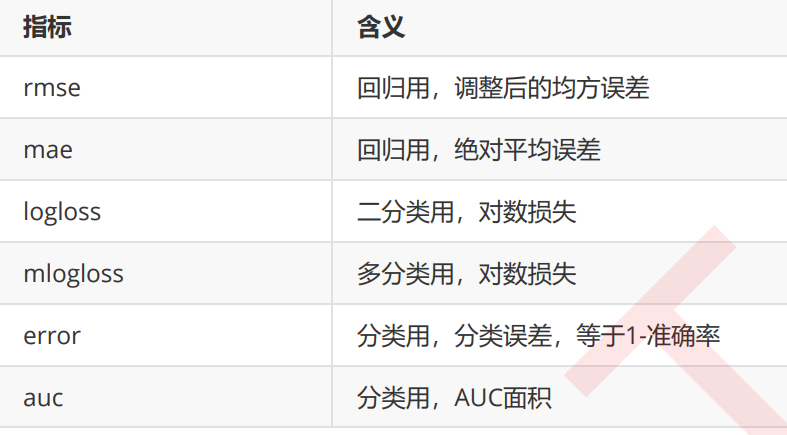

#### 从训练集得分和测试集得分初步判断泛化能力

In [2]:
def plot_learning_curve(estimator, title, x, y, cv=None, n_jobs=None):
    train_sizes, train_scores, test_scores = learning_curve(estimator
                                                            ,x
                                                            ,y
                                                            ,cv=cv
                                                            ,shuffle=True
                                                            ,n_jobs=n_jobs
                                                            ,random_state=2
                                                            ,train_sizes=[0.2,0.4,0.6,0.8,1]
                                                           )
    
    fig,ax = plt.subplots(figsize=(5,5))
    ax.set_title(title)
    ax.plot(train_sizes,train_scores.mean(axis=1),'o-',color='r',label='train score')
    ax.plot(train_sizes,test_scores.mean(axis=1),'o-',color='g',label='test score')
    ax.set_xlabel('Score')
    ax.set_xlabel('Train Size')
#     ax.set_ylim()
    ax.grid()
    ax.legend()
    return ax


<AxesSubplot:title={'center':'xgb'}, xlabel='Train Size'>

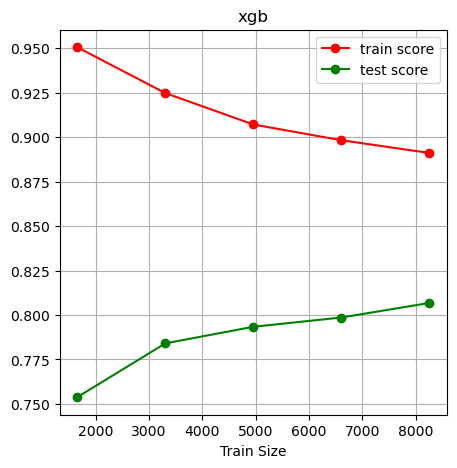

In [14]:
from sklearn.datasets import fetch_california_housing
data = fetch_california_housing()
x_train, x_test, y_train, y_test = train_test_split(data['data'], data['target'], test_size=.5) #数据有点大
xgbr = XGBRegressor(n_estimators=40, max_depth=5,random_state=2, eta=0.3)
plot_learning_curve(xgbr,'xgb',x_train, y_train, n_jobs=-1)


从data_size-score图中观察train score和test score是否趋于一致，如果train score比test score大挺多，则说明泛化能力弱，过拟合了。
如果趋于一致且score比较低说明欠拟合。  
通过调整n_estimators可以看出，n_estimators较小时会欠拟合   
另外eta=0.3(默认1)时效果有所提升，降低学习率可以避免过拟合，提高泛化能力  
通过调整max_depth可以看出，max_depth过小会欠拟合，过大会过拟合  

#### xgb.cv()确定最佳的n_estimators

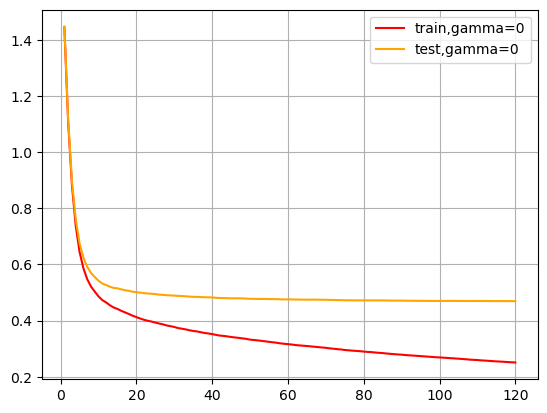

In [34]:

data = fetch_california_housing()
x_train, x_test, y_train, y_test = train_test_split(data['data'], data['target'], test_size=.1)
params = { 'eta':0.3, 'seed':3, 'eval_metric':'rmse'}
dtrain = xgb.DMatrix(x_train, y_train)
n_round = 120
n_fold = 5
time0 = time.time()
res = xgb.cv(params, dtrain, n_round, n_fold)
fig,ax = plt.subplots()
ax.plot(range(1,n_round+1),res.iloc[:,0],c="red",label="train,gamma=0")
ax.plot(range(1,n_round+1),res.iloc[:,2],c="orange",label="test,gamma=0")
ax.legend()
ax.grid()
# print(res)
# res 是DataFrame,可以看出每一轮boost的误差（得分情况），通过cv可以确认树的数量

In [ ]:
可以看出大概n_estimators=80左右是比较好的选择

#### 参数gamma 控制树复杂度，让分支停止

0.9 0.7955190946548483 0.0007595595181949059
0.5 0.7938996829713287 0.0005450829594539309
0.9 0.7955190946548483 0.0007595595181949059 0.042572000168967804


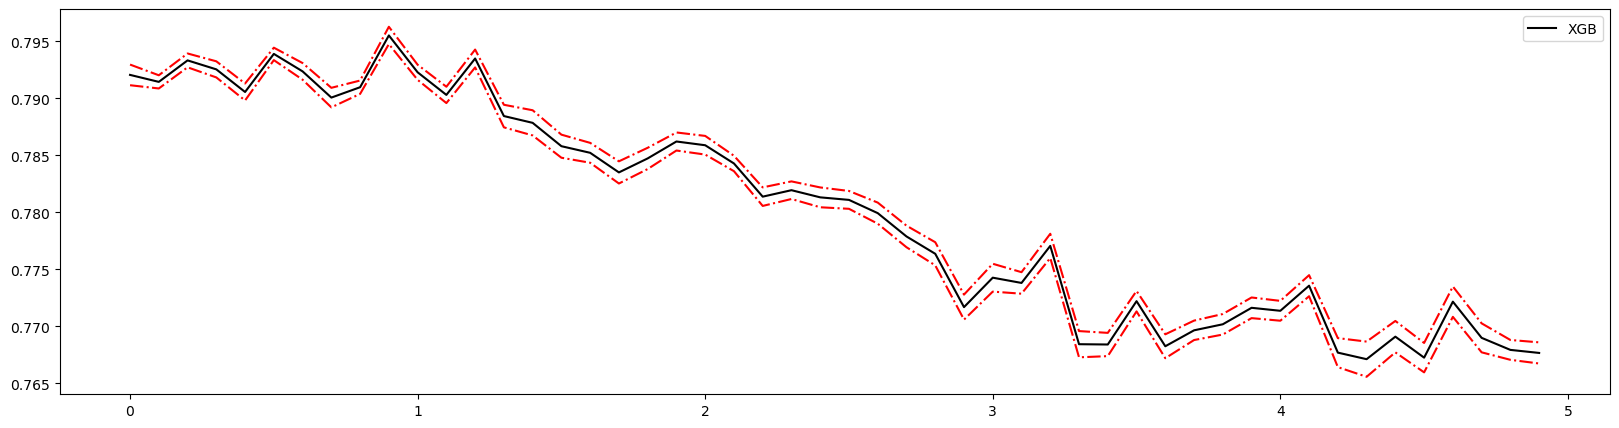

In [18]:
data = fetch_california_housing()
x_train, x_test, y_train, y_test = train_test_split(data['data'], data['target'], test_size=.8)
axisx = np.arange(0,5,0.1)
rs = []
var = []
ge = []
for i in axisx:
    reg = XGBRegressor(n_estimators=30,random_state=2,gamma=i)
    result = cross_val_score(reg,x_train,y_train,cv=10)
    rs.append(result.mean())
    var.append(result.var())
    ge.append((1 - result.mean())**2+result.var())
print(axisx[rs.index(max(rs))], max(rs), var[rs.index(max(rs))])
print(axisx[var.index(min(var))],rs[var.index(min(var))],min(var))
print(axisx[ge.index(min(ge))],rs[ge.index(min(ge))],var[ge.index(min(ge))],min(ge))
rs = np.array(rs)
var = np.array(var)
fig, ax = plt.subplots(figsize=(20,5))
ax.plot(axisx,rs,c="black",label="XGB")
ax.plot(axisx,rs+var,c="red",linestyle='-.')
ax.plot(axisx,rs-var,c="red",linestyle='-.')
ax.legend()


gamma学习曲线（gamma-score图）可以看出，gamma大概在0-1之间表现最好，1附近的方差有所减小！